# Reading data from csv

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

df = pd.read_csv('enron_spam_data.csv')
#display(df)

# Data Cleaning 

In [2]:
import re

def regexClean(message_content):
    # convert everything to string
    # getting a "passing a float" error otherwise
    message_content = str(message_content) 
    
    # remove all URLs
    message_content = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(message_content)) 

    # remove all emails
    message_content = re.sub(r'[A-Za-z0-9._\\-]+@[A-Za-z0-9-]*\\.[a-z]{2,3}','',str(message_content))

    # remove all tags
    # https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
    message_content = re.sub(r'<[^<]+?>', '', str(message_content)) 

    # remove newline
    message_content = message_content.replace('\n', ' ')

    # convert all chars to lowercase
    message_content = message_content.lower()
    return message_content

# make a copy of the df 
df_with_punct_numb_removed = df.copy();

df['Cleaned_Message'] = df['Message'].apply(regexClean)

#print(df[['Message', 'Cleaned_Message']].head())
#df_with_punct_numb_removed.head()

## punctuation and digits removed 

In [3]:
from string import punctuation

def punct_removal(message_content):
    message_content = str(message_content)
    
    # https://regexr.com/
    
    # remove digits
    message_content = re.sub(r'\d+', ' ', message_content)

    # remove all non-alphabetic characters
    message_content = message_content.replace(r'[^a-zA-Z]', '') 

    #remove punctuation
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    message_content = message_content.translate(str.maketrans('', '', punctuation))
    
    return message_content

df_with_punct_numb_removed['Cleaned_Message'] = df_with_punct_numb_removed['Message'].apply(punct_removal)

#display(df_with_punct_numb_removed)

# TFIDF 

In [5]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['Cleaned_Message']).toarray()

# Convert the vectorized data to a DataFrame for better visualization
vectorized_df = pd.DataFrame(X, columns=vectorizer.get_feature_names())

# Display the first few rows of the vectorized data
print(vectorized_df.head())

         00       000  0000        01        02   03   04   05        06   07  \
0  0.000000  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
1  0.037818  0.351393   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
2  0.000000  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.0   
3  0.000000  0.000000   0.0  0.036193  0.000000  0.0  0.0  0.0  0.044361  0.0   
4  0.000000  0.000000   0.0  0.080619  0.042999  0.0  0.0  0.0  0.000000  0.0   

   ...    yo  york       you  young  your  yours  yourself  zero  zimin  zone  
0  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
1  ...   0.0   0.0  0.008924    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
2  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
3  ...   0.0   0.0  0.032173    0.0   0.0    0.0       0.0   0.0    0.0   0.0  
4  ...   0.0   0.0  0.000000    0.0   0.0    0.0       0.0   0.0    0.0   0.0  

[5 rows x 3000 columns]


In [6]:
# Define the target variable
y = df['Spam/Ham']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start timing
start_time = time.time()

# Train the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# End timing
end_time = time.time()

# Calculate total elapsed time
total_time = end_time - start_time

# Print the results
print(f"Accuracy: {accuracy}")
print(report)
print(f"Total time elapsed for training and evaluation: {total_time:.2f} seconds")

Accuracy: 0.980723606168446
             precision    recall  f1-score   support

        ham       0.99      0.97      0.98      3276
       spam       0.97      0.99      0.98      3468

avg / total       0.98      0.98      0.98      6744

Total time elapsed for training and evaluation: 33.93 seconds


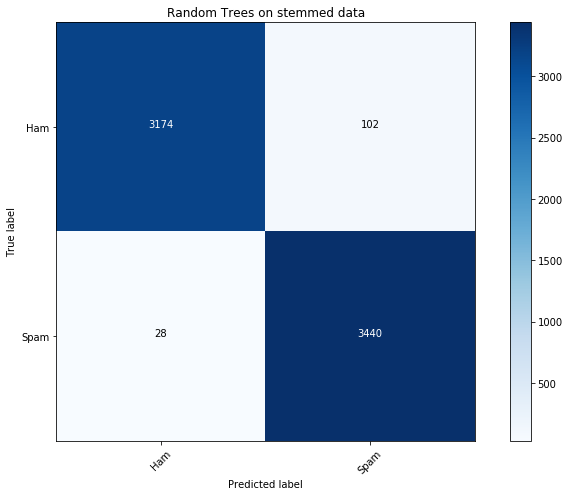

In [8]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred, class_labels=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Ham', 'Spam'], rotation=45)
    plt.yticks(tick_marks, ['Ham', 'Spam'])
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, class_labels=None, title='Random Trees on stemmed data')

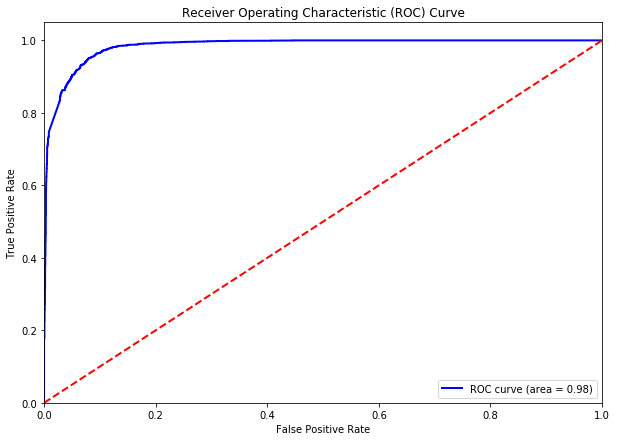

In [11]:
# ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

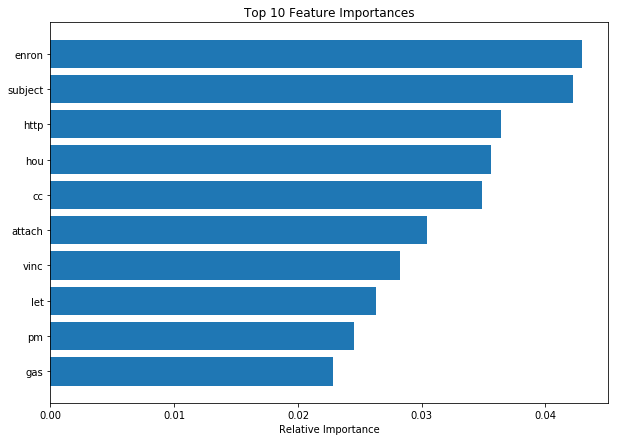

In [14]:
importances = best_model.feature_importances_
indices = sorted(range(len(importances)), key=lambda i: importances[i])[-10:]  # Top 10 features

plt.figure(figsize=(10, 7))
plt.barh(range(len(indices)), [importances[i] for i in indices], align='center')
plt.yticks(range(len(indices)), [vectorizer.get_feature_names()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importances')
plt.show()